In [1]:
import sys
import platform
import os
import random as rnd
from math import sqrt, sin, cos, radians
import numpy as np
import pandas as pd
from numba import jit
import numba
import numexpr as ne
import matplotlib.pyplot as plt
import seaborn

/Users/lukestarnes/anaconda/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
%matplotlib inline 
seaborn.set()

# Software Versions and Machine Hardware

In [3]:
print("Python: {}\nNumpy: {}\nPandas: {}\nNumba: {}\nNumexpr: {}\n{}".format(sys.version,
                                                                             np.__version__,
                                                                             pd.__version__,
                                                                             numba.__version__,
                                                                             ne.__version__,
                                                                             ne.get_vml_version()))
print("Processor: {}\n# of Cores: {}\nMachine: {}\nArchitecture: {}".format(platform.processor(),
                                                                            os.cpu_count(),
                                                                            platform.machine(),
                                                                            platform.architecture()))
#Note:
#Intel64 Family 6 Model 78 Stepping 3 = Intel(R) Core(TM) i5-6300U CPU @ 2.40GHz

Python: 3.4.5 |Anaconda 2.3.0 (x86_64)| (default, Jul  2 2016, 17:47:57) 
[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]
Numpy: 1.10.4
Pandas: 0.18.0
Numba: 0.19.1
Numexpr: 2.5.2
Intel(R) Math Kernel Library Version 11.3.3 Product Build 20160413 for Intel(R) 64 architecture applications
Processor: i386
# of Cores: 4
Machine: x86_64
Architecture: ('64bit', '')


# Define Sample Data

List of tuples where list is 1,000,000 long and each tuple has 4 values defining the point.

In [4]:
size = 1000000
points = []
for i in range(size):
    points.append((rnd.uniform(-85,85),
                   rnd.uniform(-175,175),
                   rnd.uniform(-50,12000), 
                   rnd.uniform(-50,50)))
print ('{} of {} containing {}, length: {}.'.format(type(points),type(points[0]),type(points[0][0]),len(points)))

<class 'list'> of <class 'tuple'> containing <class 'float'>, length: 1000000.


Numpy arrays, 4 arrays each 1,000,000 long.

In [5]:
#instead of using np.random.uniform to define these arrays, converting the points list
#so the same values are used for all methods
lat_np = np.empty(size, dtype=np.double)
long_np = np.empty(size, dtype=np.double)
alt_np = np.empty(size, dtype=np.double)
geoid_np = np.empty(size, dtype=np.double)
for i, point in enumerate(points):
    lat_np[i] = point[0]
    long_np[i] = point[1]
    alt_np[i] = point[2]
    geoid_np[i] = point[3]
print ('{} (x4) containing {}, length: {}.'.format(type(lat_np),type(lat_np[0]),len(lat_np)))

<class 'numpy.ndarray'> (x4) containing <class 'numpy.float64'>, length: 1000000.


Pandas DataFrame of the points.

In [6]:
points_df = pd.DataFrame(points, columns=['Lat','Long','Alt','Geoid'])
print ('{} containing {}, length: {}.'.format(type(points_df),type(points_df.ix[0,0]),len(points_df)))

<class 'pandas.core.frame.DataFrame'> containing <class 'numpy.float64'>, length: 1000000.


In [7]:
#results df
timing_results = pd.DataFrame(columns=['Loops','Repeat','Time (sec)'])
def timing_results_filler (r, return_size=3):
    returner = np.zeros(return_size)
    if return_size < 3:
        print ("error condition")
        return returner
    #Loops,Repeat,Best
    returner[0] = r.loops
    returner[1] = r.repeat
    returner[2] = r.best
    return returner

# Constants

In [8]:
a = 6378137  # Semi-major axis 
b = 6356752.3142  # Semi-minor axis
f = (a - b) / a  # flattening
e = 0.081819191 # eccentricity
ee = e*e

# Native Python Lists

In [9]:
def LLAtoXYZ_raw (latitude, longitude, altitude, geoidSepIn = 0):
    # LLAtoXYZ converts a position (latitude, longitude, altitude) to the ECEF X, Y, Z format.
    # The function expects Lat and Long in degrees and Alt in meters and outputs X, Y, Z in meters. 
    # geoidSepIn is the height of the geoid above the WGS84 ellipsoid. It is optional and assumed 
    # to be 0 if not provided (meaning geoid-to-ellipsoid differences are ignored)
    
    latitude_rad = radians(latitude)
    longitude_rad = radians(longitude)
    height = altitude - geoidSepIn
    cos_lat = cos(latitude_rad)
     
    r = a / sqrt(1 - ee * sin(latitude_rad) * sin(latitude_rad))
    x = (r + height) * cos_lat * cos(longitude_rad)
    y = (r + height) * cos_lat * sin(longitude_rad)
    z = ((1 - ee) * r + height) * sin(latitude_rad)
        
    return x,y,z
LLAtoXYZ_raw(-38.123456,-124.65432,230,-20)
#X= -2856867.422762463
#Y= -4132876.8004144537
#Z= -3916387.577890978

(-2856867.422762463, -4132876.8004144537, -3916387.577890978)

In [10]:
results = []
r = %timeit -n 50 -r 5 -o for p in points: results.append(LLAtoXYZ_raw(p[0],p[1],p[2],p[3]))
timing_results.loc['Native Python'] = timing_results_filler(r, len(timing_results.columns))

50 loops, best of 5: 1.88 s per loop


# Numpy Arrays

In [11]:
#import numpy functions directly
from numpy import sqrt, sin, cos, radians

In [12]:
def LLAtoXYZ_numpy (latitude, longitude, altitude, geoidSepIn = 0, return_array = False):
    # LLAtoXYZ converts a position (latitude, longitude, altitude) to the ECEF X, Y, Z format.
    # The function expects Lat and Long in degrees and Alt in meters and outputs X, Y, Z in meters. 
    # geoidSepIn is the height of the geoid above the WGS84 ellipsoid. It is optional and assumed 
    # to be 0 if not provided (meaning geoid-to-ellipsoid differences are ignored)
    
    latitude_rad = radians(latitude)
    longitude_rad = radians(longitude)
    height = altitude - geoidSepIn
    cos_lat = cos(latitude_rad)
     
    r = a / sqrt(1 - ee * sin(latitude_rad) * sin(latitude_rad))
    x = (r + height) * cos_lat * cos(longitude_rad)
    y = (r + height) * cos_lat * sin(longitude_rad)
    z = ((1 - ee) * r + height) * sin(latitude_rad)
    
    if return_array:
        return np.array([x,y,z])
    else:
        return x,y,z
    
LLAtoXYZ_numpy(-38.123456,-124.65432,230,-20)
#X= -2856867.422762463
#Y= -4132876.8004144537
#Z= -3916387.577890978

(-2856867.4227624629, -4132876.8004144537, -3916387.5778909782)

In [13]:
r = %timeit -n 50 -r 5 -o results=LLAtoXYZ_numpy(lat_np,long_np,alt_np,geoid_np,True)
timing_results.loc['Numpy (Native)'] = timing_results_filler(r, len(timing_results.columns))

50 loops, best of 5: 201 ms per loop


# Pandas (Serialized)
added to show how slow pandas can be if not vectorized

In [14]:
#r = %timeit -n 5 -r 5 -o points_df['X'],points_df['Y'],points_df['Z'] = zip(*points_df.apply(lambda row: LLAtoXYZ_raw(row[0],row[1],row[2],row[3]), axis=1))
#timing_results.loc['Pandas (Serialized)'] = timing_results_filler(r)

# Pandas (Vectorized)

In [15]:
r = %timeit -n 50 -r 5 -o points_df['X'],points_df['Y'],points_df['Z'] = LLAtoXYZ_numpy(points_df['Lat'],points_df['Long'],points_df['Alt'],points_df['Geoid'],False)
timing_results.loc['Pandas (Native)'] = timing_results_filler(r, len(timing_results.columns))

50 loops, best of 5: 198 ms per loop


# Numba

In [16]:
@jit
def LLAtoXYZ_jit (latitude, longitude, altitude, geoidSepIn = 0, return_array = False):
    # LLAtoXYZ converts a position (latitude, longitude, altitude) to the ECEF X, Y, Z format.
    # The function expects Lat and Long in degrees and Alt in meters and outputs X, Y, Z in meters. 
    # geoidSepIn is the height of the geoid above the WGS84 ellipsoid. It is optional and assumed 
    # to be 0 if not provided (meaning geoid-to-ellipsoid differences are ignored)
    
    latitude_rad = radians(latitude)
    longitude_rad = radians(longitude)
    height = altitude - geoidSepIn
    cos_lat = cos(latitude_rad)
     
    r = a / np.sqrt(1 - ee * sin(latitude_rad) * sin(latitude_rad))
    x = (r + height) * cos_lat * cos(longitude_rad)
    y = (r + height) * cos_lat * sin(longitude_rad)
    z = ((1 - ee) * r + height) * sin(latitude_rad)
    
    if return_array:
        return np.array([x,y,z])
    else:
        return x,y,z
    
LLAtoXYZ_jit(-38.123456,-124.65432,230,-20)
#X= -2856867.422762463
#Y= -4132876.8004144537
#Z= -3916387.577890978

(-2856867.4227624629, -4132876.8004144537, -3916387.5778909782)

In [17]:
r = %timeit -n 50 -r 5 -o results = LLAtoXYZ_jit(lat_np,long_np,alt_np,geoid_np,True)
timing_results.loc['Numba (with Numpy Arrays)'] = timing_results_filler(r, len(timing_results.columns))

50 loops, best of 5: 201 ms per loop


In [18]:
r = %timeit -n 50 -r 5 -o points_df['X'],points_df['Y'],points_df['Z'] = LLAtoXYZ_jit(points_df['Lat'],points_df['Long'],points_df['Alt'],points_df['Geoid'],False)
timing_results.loc['Numba (with Pandas)'] = timing_results_filler(r, len(timing_results.columns))

50 loops, best of 5: 209 ms per loop


# Numexpr

In [19]:
def LLAtoXYZ_ne (latitude, longitude, altitude, geoidSepIn = 0, return_array = False):
    # LLAtoXYZ converts a position (latitude, longitude, altitude) to the ECEF X, Y, Z format.
    # The function expects Lat and Long in degrees and Alt in meters and outputs X, Y, Z in meters. 
    # geoidSepIn is the height of the geoid above the WGS84 ellipsoid. It is optional and assumed 
    # to be 0 if not provided (meaning geoid-to-ellipsoid differences are ignored)
    
    latitude_rad = radians(latitude)
    longitude_rad = radians(longitude)
    height = altitude - geoidSepIn
     
    r = ne.evaluate("a / sqrt(1 - ee * sin(latitude_rad)**2)")
    x = ne.evaluate("(r + height) * cos(latitude_rad) * cos(longitude_rad)")
    y = ne.evaluate("(r + height) * cos(latitude_rad) * sin(longitude_rad)")
    z = ne.evaluate("((1 - ee) * r + height) * sin(latitude_rad)")
    
    if return_array:
        return np.array([x,y,z])
    else:
        return x,y,z
    
LLAtoXYZ_ne(-38.123456,-124.65432,230,-20)
#X= -2856867.422762463
#Y= -4132876.8004144537
#Z= -3916387.577890978

(array(-2856867.422762463),
 array(-4132876.8004144537),
 array(-3916387.577890978))

In [20]:
r = %timeit -n 50 -r 5 -o results = LLAtoXYZ_ne(lat_np,long_np,alt_np,geoid_np,True)
timing_results.loc['Numexpr (with Numpy Arrays)'] = timing_results_filler(r, len(timing_results.columns))

50 loops, best of 5: 51.2 ms per loop


In [21]:
r = %timeit -n 50 -r 5 -o points_df['X'],points_df['Y'],points_df['Z'] = LLAtoXYZ_ne(points_df['Lat'],points_df['Long'],points_df['Alt'],points_df['Geoid'],False)
timing_results.loc['Numexpr (with Pandas)'] = timing_results_filler(r, len(timing_results.columns))

50 loops, best of 5: 56.2 ms per loop


# Cython

In [22]:
%load_ext Cython

In [23]:
%%cython
from cython cimport boundscheck, wraparound
from libc.math cimport sin, cos, sqrt, M_PI
import numpy as np
cimport numpy as cnp

cdef double geoidSep = -29.701  # meters 

cdef double a = 6378137       # Semi-major axis 
cdef double b = 6356752.3142  # Semi-minor axis
cdef double f = (a - b) / a   # flattening
cdef double e = 0.081819191
cdef double ecc = e*e
cdef double radians = M_PI/180.0

@boundscheck(False)
@wraparound(False)
def LLAtoXYZ_cy(double[:] latitude, 
                double[:] longitude, 
                double[:] altitude, 
                double[:] geoidSepIn):
    cdef int i
    cdef int l = len(latitude)
    
    cdef double[:] x = np.empty(l, dtype=np.double)
    cdef double[:] y = np.empty(l, dtype=np.double)
    cdef double[:] z = np.empty(l, dtype=np.double)
    
    cdef double latitude_rad
    cdef double longitude_rad
    cdef double height
    cdef double s_lat
    cdef double c_lat
    cdef double r
    
    for i in range(l):
        latitude_rad = radians*latitude[i]
        longitude_rad = radians*longitude[i]
        height = altitude[i] - geoidSepIn[i]
        s_lat  = sin(latitude_rad)
        c_lat  = cos(latitude_rad)
         
        r = a / sqrt(1 - ecc * s_lat * s_lat)
        x[i] = (r + height) * c_lat * cos(longitude_rad)
        y[i] = (r + height) * c_lat * sin(longitude_rad)
        z[i] = ((1-ecc) * r + height) * s_lat
        
    return x,y,z

/Users/lukestarnes/anaconda/lib/python3.4/site-packages/IPython/utils/path.py:264: UserWarning: get_ipython_cache_dir has moved to the IPython.paths module
  warn("get_ipython_cache_dir has moved to the IPython.paths module")


In [24]:
results_c = LLAtoXYZ_cy(np.array([-38.123456], dtype=np.double),
                     np.array([-124.65432], dtype=np.double),
                     np.array([230], dtype=np.double),
                       np.array([-20], dtype=np.double))
print (results_c[0][0], results_c[1][0], results_c[2][0])
#X= -2856867.422762463
#Y= -4132876.8004144537
#Z= -3916387.577890978)

-2856867.422762463 -4132876.8004144537 -3916387.577890978


In [25]:
r = %timeit -n 50 -r 5 -o results=LLAtoXYZ_cy(lat_np,long_np,alt_np,geoid_np)
timing_results.loc['Cython (with Numpy Arrays)'] = timing_results_filler(r, len(timing_results.columns))

50 loops, best of 5: 79.8 ms per loop


# Cython (parallel)

In [26]:
%%cython
from cython cimport boundscheck, wraparound
from cython.parallel cimport prange
from libc.math cimport sin, cos, sqrt, M_PI
import numpy as np
cimport numpy as cnp

cdef double geoidSep = -29.701  # meters 

cdef double a = 6378137       # Semi-major axis 
cdef double b = 6356752.3142  # Semi-minor axis
cdef double f = (a - b) / a   # flattening
cdef double e = 0.081819191
cdef double ecc = e*e
cdef double radians = M_PI/180.0

@boundscheck(False)
@wraparound(False)
def LLAtoXYZ_cy_par(double[:] latitude, 
                double[:] longitude, 
                double[:] altitude, 
                double[:] geoidSepIn):
    cdef int i
    cdef int l = len(latitude)
    
    cdef double[:] x = np.empty(l, dtype=np.double)
    cdef double[:] y = np.empty(l, dtype=np.double)
    cdef double[:] z = np.empty(l, dtype=np.double)
    
    cdef double latitude_rad
    cdef double longitude_rad
    cdef double height
    cdef double s_lat
    cdef double c_lat
    cdef double r
    
    for i in prange(l, nogil=True):
        latitude_rad = radians*latitude[i]
        longitude_rad = radians*longitude[i]
        height = altitude[i] - geoidSepIn[i]
        s_lat  = sin(latitude_rad)
        c_lat  = cos(latitude_rad)
         
        r = a / sqrt(1 - ecc * s_lat * s_lat)
        x[i] = (r + height) * c_lat * cos(longitude_rad)
        y[i] = (r + height) * c_lat * sin(longitude_rad)
        z[i] = ((1-ecc) * r + height) * s_lat
        
    return x,y,z

/Users/lukestarnes/anaconda/lib/python3.4/site-packages/IPython/utils/path.py:264: UserWarning: get_ipython_cache_dir has moved to the IPython.paths module
  warn("get_ipython_cache_dir has moved to the IPython.paths module")


In [27]:
results_c = LLAtoXYZ_cy(np.array([-38.123456], dtype=np.double),
                     np.array([-124.65432], dtype=np.double),
                     np.array([230], dtype=np.double),
                       np.array([-20], dtype=np.double))
print (results_c[0][0], results_c[1][0], results_c[2][0])
#X= -2856867.422762463
#Y= -4132876.8004144537
#Z= -3916387.577890978)

-2856867.422762463 -4132876.8004144537 -3916387.577890978


In [28]:
r = %timeit -n 50 -r 5 -o results=LLAtoXYZ_cy_par(lat_np,long_np,alt_np,geoid_np)
timing_results.loc['Cython.Parallel (with Numpy Arrays)'] = timing_results_filler(r,len(timing_results.columns))

50 loops, best of 5: 80.4 ms per loop


# Summary

In [29]:
timing_results['Num of Points'] = size
timing_results['Vs Native Python'] = timing_results.loc['Native Python']['Time (sec)'] / timing_results['Time (sec)']
timing_results['Time per Point (usec)'] = timing_results['Time (sec)'] / size * 1000000

In [30]:
timing_results.to_csv(str(int(size/1000))+'K_pts.csv')
timing_results.sort_values('Time (sec)')

,Loops,Repeat,Time (sec),Num of Points,Vs Native Python,Time per Point (usec)
Numexpr (with Numpy Arrays),50.0,5.0,0.051233,1000000,36.780134,0.051233
Numexpr (with Pandas),50.0,5.0,0.056174,1000000,33.544541,0.056174
Cython (with Numpy Arrays),50.0,5.0,0.079799,1000000,23.613501,0.079799
Cython.Parallel (with Numpy Arrays),50.0,5.0,0.080378,1000000,23.443561,0.080378
Pandas (Native),50.0,5.0,0.197725,1000000,9.530100,0.197725
Numba (with Numpy Arrays),50.0,5.0,0.200761,1000000,9.385973,0.200761
Numpy (Native),50.0,5.0,0.201355,1000000,9.358271,0.201355
Numba (with Pandas),50.0,5.0,0.208601,1000000,9.033205,0.208601
Native Python,50.0,5.0,1.884338,1000000,1.000000,1.884338


Ran the time tests for both 10K and 1M points.

In [41]:
tenK_df = pd.read_csv('10K_pts.csv')
oneM_df = pd.read_csv('1000K_pts.csv')
oneM_df.set_index('Unnamed: 0', inplace=True)
tenK_df.set_index('Unnamed: 0', inplace=True)
tenK_df.index.name = 'Method'
oneM_df.index.name = 'Method'

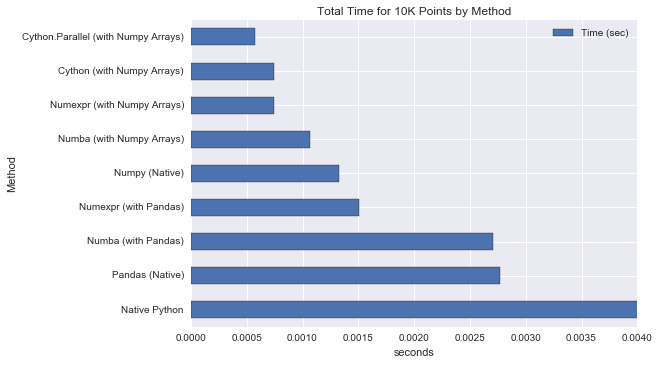

In [71]:
tenK_df.sort_values('Time (sec)', inplace=True, ascending=False)
tenK_df_subset = tenK_df.reindex(columns=['Time (sec)'])
ax_10k_time = tenK_df_subset.plot(kind='barh')
ax_10k_time.set_yticklabels(list(tenK_df.index))
ax_10k_time.set_xbound(upper=.004)
ax_10k_time.set_xlabel('seconds')
ax_10k_time.set_title('Total Time for 10K Points by Method')
plt.savefig('time_10k.png')

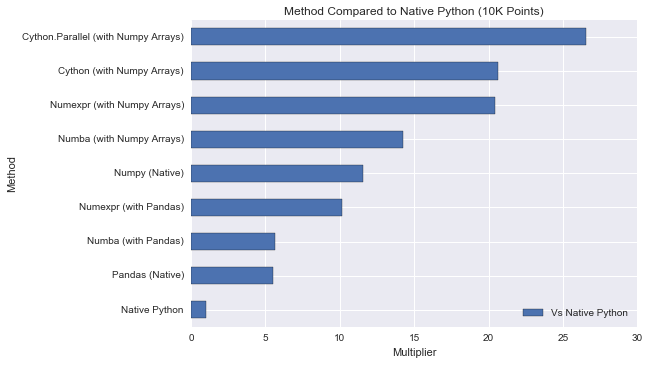

In [72]:
tenK_df.sort_values('Vs Native Python', inplace=True, ascending=True)
tenK_df_subset = tenK_df.reindex(columns=['Vs Native Python'])
ax_10k_vs = tenK_df_subset.plot(kind='barh')
ax_10k_vs.set_yticklabels(list(tenK_df.index))
ax_10k_vs.set_xlabel('Multiplier')
ax_10k_vs.set_title('Method Compared to Native Python (10K Points)')
plt.savefig('compare_10k.png')

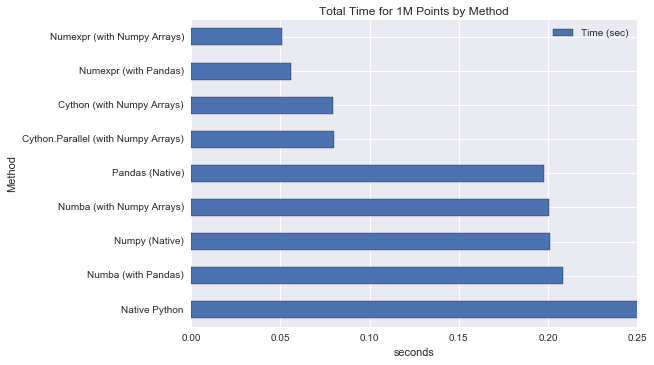

In [73]:
oneM_df.sort_values('Time (sec)', inplace=True, ascending=False)
oneM_df_subset = oneM_df.reindex(columns=['Time (sec)'])
ax_1M_time = oneM_df_subset.plot(kind='barh')
ax_1M_time.set_yticklabels(list(oneM_df.index))
ax_1M_time.set_xbound(upper=.25)
ax_1M_time.set_xlabel('seconds')
ax_1M_time.set_title('Total Time for 1M Points by Method')
plt.savefig('time_1M.png')

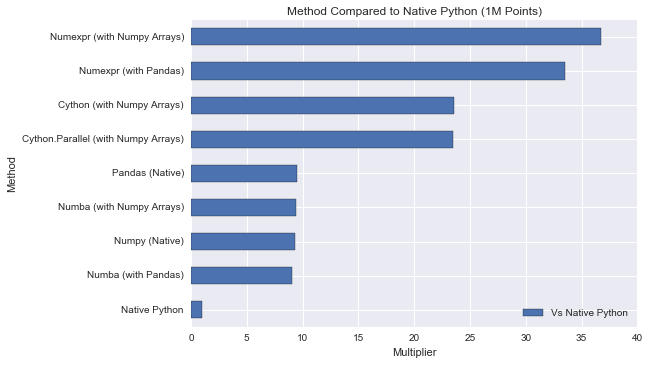

In [74]:
oneM_df.sort_values('Vs Native Python', inplace=True, ascending=True)
oneM_df_subset = oneM_df.reindex(columns=['Vs Native Python'])
ax_1M_vs = oneM_df_subset.plot(kind='barh')
ax_1M_vs.set_yticklabels(list(oneM_df.index))
ax_1M_vs.set_xlabel('Multiplier')
ax_1M_vs.set_title('Method Compared to Native Python (1M Points)')
plt.savefig('compare_1M.png')

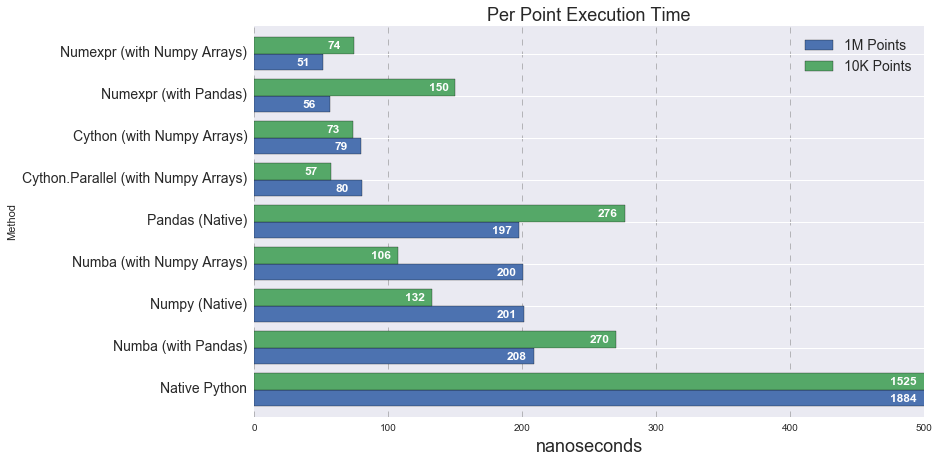

In [63]:
oneM_per_pt = pd.Series(oneM_df['Time per Point (usec)'],name='1M Points')
tenK_per_pt = pd.Series(tenK_df['Time per Point (usec)'],name='10K Points')
oneM_per_pt = oneM_per_pt * 1000
tenK_per_pt = tenK_per_pt * 1000
per_pt_df = pd.concat((oneM_per_pt, tenK_per_pt),axis=1)
per_pt_df.sort_values('1M Points', inplace=True, ascending=False)
ax_per_pt = per_pt_df.plot(kind='barh', width = .8, figsize=(12,7))
ax_per_pt.set_xbound(upper=500)
ax_per_pt.set_title('Per Point Execution Time', fontsize=18)
ax_per_pt.set_xlabel('nanoseconds', fontsize=18)
ax_per_pt.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.5)
plt.legend(fontsize=14)
rects = ax_per_pt.patches
labels = per_pt_df.values.flatten('F')
ax_per_pt.tick_params(axis='y', labelsize=14)
for rect, label in zip(rects, labels):
    width = rect.get_width()
    height = rect.get_height()
    ax_per_pt.text(min(width - 20, 475), rect.get_y()+ height*3/4, int(label), color='white',fontsize=12, ha='left', va='top', weight='heavy')
plt.savefig('exec_time.png')

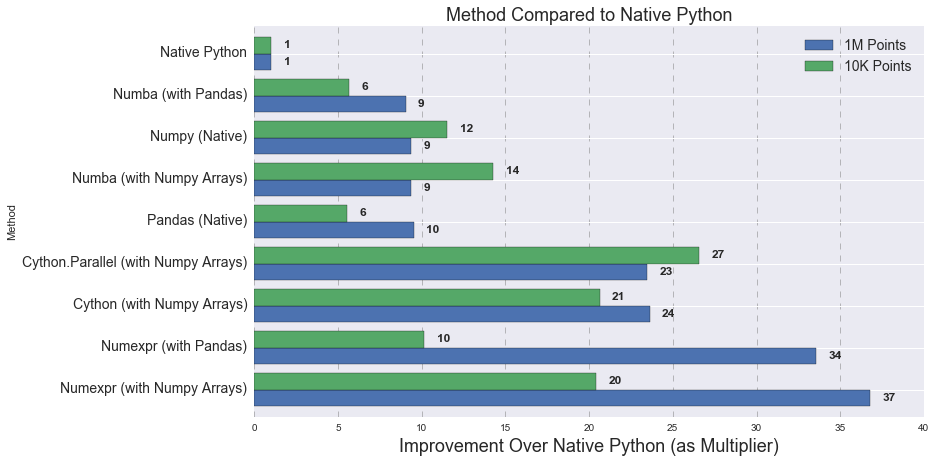

In [66]:
oneM_vs = pd.Series(oneM_df['Vs Native Python'],name='1M Points')
tenK_vs = pd.Series(tenK_df['Vs Native Python'],name='10K Points')
vs_df = pd.concat((oneM_vs, tenK_vs),axis=1)
vs_df.sort_values('1M Points', inplace=True, ascending=False)
ax_vs = vs_df.plot(kind='barh', width = .8, figsize=(12,7))
ax_vs.set_title('Method Compared to Native Python', fontsize=18)
ax_vs.set_xlabel('Improvement Over Native Python (as Multiplier)', fontsize=18)
ax_vs.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.5)
plt.legend(fontsize=14)
rects = ax_vs.patches
labels = vs_df.values.flatten('F')
labels = np.rint(labels)
ax_vs.tick_params(axis='y', labelsize=14)
for rect, label in zip(rects, labels):
    width = rect.get_width()
    ax_vs.text(width + 0.75, rect.get_y() + height/2, int(label), fontsize=12, ha='left', va='center', weight='heavy')
plt.savefig('method_compare.png')